In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

/Users/smoothoperator/opt/anaconda3/envs/smoothenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
words = open('names.txt','r').read().splitlines()
print(len(words))
words[:8]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
#build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
#Now made somewhat respectable :) -----------------

In [7]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [8]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [9]:
#making loss.backward() useful
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters) #total number of parameters

11897

In [10]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
#store values during training
lri = []
lossi = []
stepi = []


In [11]:
#Forward Pass with batches


#forward pass
for i in range(200000):


    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    emb = C[Xtr[ix]] #embeddings of a batch

    h = torch.tanh(emb.view(-1,30) @ W1 + b1) #.view() for mat mul 
    logits = h @ W2 + b2
    #print(logits.shape)
    '''counts = logits.exp()
    probs = counts / counts.sum(-1, keepdims = True)
    loss = -probs[torch.arange(32), Y].log().mean()'''
    #why do CE, pytorch wont create these intermediate tensors which is inefficient
    #backwar pass is more efficient, 
    loss = F.cross_entropy(logits,Ytr[ix])
    for p in parameters:
        p.grad = None
    loss.backward()

    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    #lri.append(lrs[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())

1.8313672542572021


In [12]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1275, grad_fn=<NllLossBackward>)

In [13]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1671, grad_fn=<NllLossBackward>)

In [ ]:
'''# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss'''

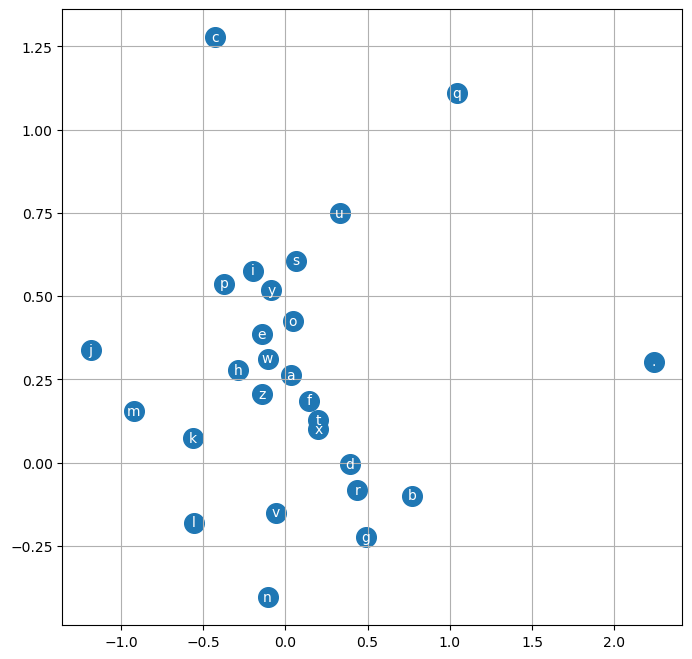

In [14]:
'''
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,0].item(), itos[i], ha = "center", va = "center", color = "red")
plt.grid('minor')
'''
#this shows the embedding vectors
# 
# 
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [127]:
"""#Forward Pass
for _ in range(1000):
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    '''counts = logits.exp()
    probs = counts / counts.sum(-1, keepdims = True)
    loss = -probs[torch.arange(32), Y].log().mean()'''
    #why do CE, pytorch wont create these intermediate tensors which is inefficient
    #backwar pass is more efficient, 
    loss = F.cross_entropy(logits,Y)
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad

print(loss.item())"""

"#Forward Pass\nfor _ in range(1000):\n    emb = C[X]\n    h = torch.tanh(emb.view(-1,6) @ W1 + b1)\n    logits = h @ W2 + b2\n    '''counts = logits.exp()\n    probs = counts / counts.sum(-1, keepdims = True)\n    loss = -probs[torch.arange(32), Y].log().mean()'''\n    #why do CE, pytorch wont create these intermediate tensors which is inefficient\n    #backwar pass is more efficient, \n    loss = F.cross_entropy(logits,Y)\n    for p in parameters:\n        p.grad = None\n    loss.backward()\n    for p in parameters:\n        p.data += -0.1*p.grad\n\nprint(loss.item())"

- how to improve the model, steps:
- inceras the embedding mpodel sizes
- increase the neruons in hidden layers

In [124]:
#we arrive at the conclusion that 10**(-1) is an optimal learning rate